# TODO:
- trzeba się zastanowić jakie zakres hyper parametrów bierzemy - ADAM -TODO
- sprawdić jak zmiana seed w random search wpływa na wyniki tunowalnośći (sampling bias) - TODO (zmienaimy seed i patrzymy czy tunowalność się zmienia -> tabelka z 10 seedami i patrzyma jak zmienia się tunowalnosć) -TODO ( przy pisaniu raportu)

### Imports

In [1]:
import itertools
import random
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas import DataFrame, Series
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from skopt.space import Integer, Real

from utills.best_config_bayes import (
    find_best_config_using_bayes,
    find_best_configs_in_search_space_with_bayes,
)
from utills.best_config_random_search import (
    find_best_configs_in_search_space_with_random_search,
)
from utills.dataset import load_dataset_from_id, split_dataset
from utills.dump_data import (
    dump_optimal_config_search_history,
    dump_scores_to_csv,
    dump_tunability_to_csv,
)
from utills.optimal_config import find_optimal_configuration_for_all_datasets
from utills.pipeline import get_column_transformer
from utills.tunability import (
    calculate_aggregate_tunability,
    calculate_tunability_on_each_dataset,
)

# Constants

In [2]:
NUM_ITER_BAYES = 5
NUM_POINTS_RS_DECISION_TREE = 100
NUM_POINTS_RS_ELASTIC_NET = 100
NUM_POINTS_RS_RANDOM_FOREST = 100

### Utill functions

### Load datasets

In [3]:
fish_market_dataset_id = (
    43308  # https://www.openml.org/search?type=data&id=43308&sort=runs&status=active
)
cars_dataset_id = (
    44994  # https://www.openml.org/search?type=data&status=active&id=44994
)
diabetes_dataset_id = (
    44223  # https://www.openml.org/search?type=data&id=44223&sort=runs&status=active
)

lisbona_house_prices_dataset_id = (
    43660  # https://www.openml.org/search?type=data&id=43660&sort=runs&status=active
)


fish_market_dataset: DataFrame = load_dataset_from_id(id=fish_market_dataset_id)
fish_market_regression_class = "Weight"

cars_dataset: DataFrame = load_dataset_from_id(id=cars_dataset_id)
cars_regression_class = "Price"

diabetes_dataset: DataFrame = load_dataset_from_id(id=diabetes_dataset_id)
diabetes_regression_class = "class"

lisbona_house_prices_dataset: DataFrame = load_dataset_from_id(
    id=lisbona_house_prices_dataset_id
)
lisbona_house_prices_regression_class = "Price"

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` 

### Split data into train and test sets

In [4]:
(
    X_train_fish_market,
    X_test_fish_market,
    y_train_fish_market,
    y_test_fish_market,
) = split_dataset(data=fish_market_dataset, class_=fish_market_regression_class)

(
    X_train_cars,
    X_test_cars,
    y_train_cars,
    y_test_cars,
) = split_dataset(data=cars_dataset, class_=cars_regression_class)

X_train_diabetes, X_test_diabetes, y_train_diabetes, y_test_diabetes = split_dataset(
    diabetes_dataset, diabetes_regression_class
)

(
    X_train_lisbona_house_prices,
    X_test_lisbona_house_prices,
    y_train_lisbona_house_prices,
    y_test_lisbona_house_prices,
) = split_dataset(lisbona_house_prices_dataset, lisbona_house_prices_regression_class)

In [5]:
def get_train_datasets() -> List[Tuple[DataFrame, Series]]:
    return [
        (X_train_fish_market, y_train_fish_market),
        (X_train_cars, y_train_cars),
        (X_train_diabetes, y_train_diabetes),
        (X_train_lisbona_house_prices, y_train_lisbona_house_prices),
    ]

In [6]:
def get_test_datasets():
    return [
        (X_test_fish_market, y_test_fish_market),
        (X_test_cars, y_test_cars),
        (X_test_diabetes, y_test_diabetes),
        (X_test_lisbona_house_prices, y_test_lisbona_house_prices),
    ]


# 1. Decision Tree

## Prepare model and search space

In [7]:
def get_decision_tree_pipeline() -> Pipeline:
    decision_tree = DecisionTreeRegressor()
    col_trans: ColumnTransformer = get_column_transformer()
    decision_tree_pipeline = Pipeline(
        steps=[("column_transformer", col_trans), ("model", decision_tree)]
    )
    return decision_tree_pipeline

In [8]:
def get_parameter_grid_decision_tree():
    # parameters space
    random.seed(42)
    ccp_alpha_values = [i * 0.1 for i in range(11)]

    max_depth_values = range(1, 31, 1)

    min_samples_split_values = range(2, 61, 1)

    min_samples_leaf_values = range(1, 61, 1)

    all_combinations = list(
        itertools.product(
            ccp_alpha_values,
            max_depth_values,
            min_samples_split_values,
            min_samples_leaf_values,
        )
    )

    selected_combinations: List[Tuple[float, int, int, int]] = random.sample(
        all_combinations, NUM_POINTS_RS_DECISION_TREE
    )

    parameter_names = [
        "model__ccp_alpha",
        "model__max_depth",
        "model__min_samples_split",
        "model__min_samples_leaf",
    ]

    config_grid = [
        dict(zip(parameter_names, combination)) for combination in selected_combinations
    ]

    return config_grid

## Find optimal default hyperparameters 

In [10]:
# find teta*

(
    optimal_config_decision_tree,
    best_summary_score_decision_tree,
    history_scores,
) = find_optimal_configuration_for_all_datasets(
    config_space=get_parameter_grid_decision_tree(),
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    model=get_decision_tree_pipeline(),
    summary_func=np.mean,  # Or np.median for a more robust approach
)
dump_optimal_config_search_history(
    history_scores, "output_data/decision_tree/optimal_config_search_history.csv"
)

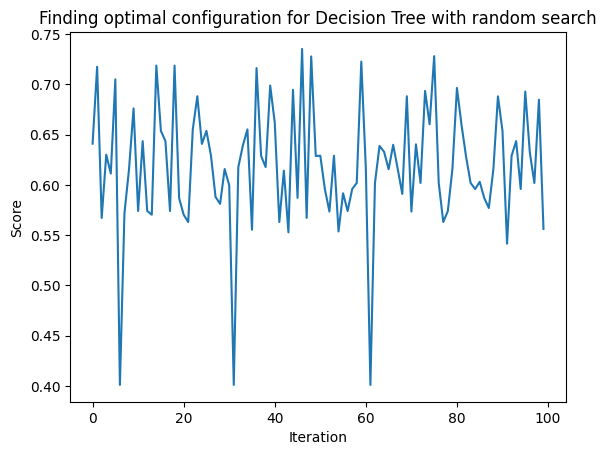

In [11]:
plt.plot(history_scores)
plt.xlabel("Iteration")
plt.ylabel("Score")
plt.title("Finding optimal configuration for Decision Tree with random search")
plt.show()

In [12]:
print(optimal_config_decision_tree)
print(best_summary_score_decision_tree)

{'model__ccp_alpha': 0.7000000000000001, 'model__max_depth': 5, 'model__min_samples_split': 16, 'model__min_samples_leaf': 4}
0.7353826766114201


## Evaluate model with optimal hyperparameters on each dataset

In [13]:
for train_dataset, test_dataset in zip(get_train_datasets(), get_test_datasets()):
    optimal_model: Pipeline = get_decision_tree_pipeline()
    optimal_model.set_params(**optimal_config_decision_tree)
    optimal_model.fit(train_dataset[0], train_dataset[1])
    score = optimal_model.score(test_dataset[0], test_dataset[1])
    print("Optimal decision tree score on dataset : " + str(score))

Optimal decision tree score on dataset : 0.9643548213621457
Optimal decision tree score on dataset : 0.9117940952248595
Optimal decision tree score on dataset : 0.36726402573053707
Optimal decision tree score on dataset : 0.698117764128138


## Find best hyperparameters for given dataset with random search

In [14]:
# find tate^(j)*
(
    best_decision_tree_configs_for_each_dataset,
    list_iteration_scores,
) = find_best_configs_in_search_space_with_random_search(
    pipeline=get_decision_tree_pipeline(),
    config_space=get_parameter_grid_decision_tree(),
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
)
for i, iteration_scores in enumerate(list_iteration_scores):
    dump_scores_to_csv(
        iteration_scores,
        f"output_data/decision_tree/random_search_iteration_scores_dataset_{i}.csv",
    )

dataset: 0
score: 0.9643548213621457
best config: {'model__ccp_alpha': 0.7000000000000001, 'model__max_depth': 5, 'model__min_samples_split': 16, 'model__min_samples_leaf': 4}
dataset: 1
score: 0.9202597484618898
best config: {'model__ccp_alpha': 0.7000000000000001, 'model__max_depth': 27, 'model__min_samples_split': 38, 'model__min_samples_leaf': 4}
dataset: 2
score: 0.46184442507636947
best config: {'model__ccp_alpha': 0.4, 'model__max_depth': 18, 'model__min_samples_split': 51, 'model__min_samples_leaf': 6}
dataset: 3
score: 0.698117764128138
best config: {'model__ccp_alpha': 0.7000000000000001, 'model__max_depth': 5, 'model__min_samples_split': 16, 'model__min_samples_leaf': 4}


In [ ]:
for i, iteration_scores in enumerate(list_iteration_scores):
    plt.plot(iteration_scores)
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(f"Random Search on dataset {i}")
    plt.show()

## Calculate tunability on each dataset

In [15]:
# find d^j
tunability_per_dataset = calculate_tunability_on_each_dataset(
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    best_configs=best_decision_tree_configs_for_each_dataset,
    optimal_config=optimal_config_decision_tree,
    get_model_pipeline=get_decision_tree_pipeline,
)
dump_tunability_to_csv(
    tunability_per_dataset=tunability_per_dataset,
    filepath="output_data/decision_tree/random_search_tunability.csv",
)

d^j: 0.0
d^j: -0.008465653237030302
d^j: -0.0945803993458324
d^j: 0.0


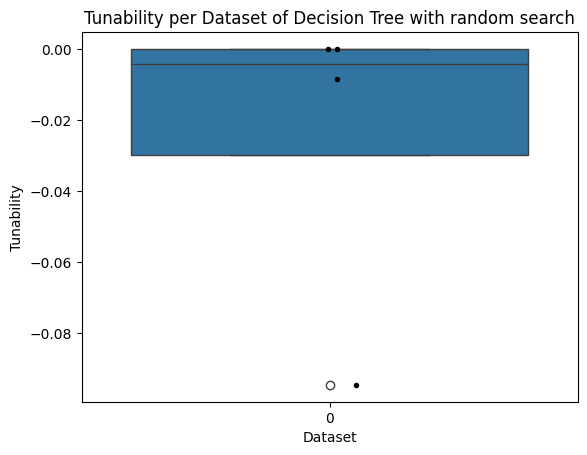

In [16]:
tunability_data = [tunability_per_dataset]

sns.boxplot(data=tunability_data)

# add strip plot
sns.stripplot(data=tunability_data, color="black", size=4)

# add labels and title
plt.xlabel("Dataset")
plt.ylabel("Tunability")
plt.title("Tunability per Dataset of Decision Tree with random search")

# show the plot
plt.show()

In [17]:
# aggregated tunability d
print(
    "Aggregated tunability d: "
    + str(calculate_aggregate_tunability(tunability_per_dataset))
)

Aggregated tunability d: -0.025761513145715675


## Find best hyperparameters for given dataset with bayesian search

In [18]:
def get_bayes_search_space_decision_tree():
    return (
        {
            "model__ccp_alpha": Real(0.0, 1.0),
            "model__max_depth": Integer(1, 30),
            "model__min_samples_split": Integer(2, 60),
            "model__min_samples_leaf": Integer(1, 60),
        },
        NUM_ITER_BAYES,
    )

In [19]:
np.int = np.int64  # hack so numpy doesn't complain about missing np.int :)
# calculate all configs
(
    best_configs_for_decision_tree,
    histories,
) = find_best_configs_in_search_space_with_bayes(
    search_space=get_bayes_search_space_decision_tree(),
    pipeline=get_decision_tree_pipeline(),
    train_datasets=get_train_datasets(),
)
for i, history in enumerate(histories):
    dump_scores_to_csv(
        history, f"output_data/decision_tree/bayes_iteration_scores_dataset_{i}.csv"
    )

Iteration 1: Score = 0.7781497879594955
Iteration 2: Score = 0.7865466239620986
Iteration 3: Score = 0.6399236831654218
Iteration 4: Score = 0.7814191177978664
Iteration 5: Score = 0.7862352697558779
Best score: 0.7865466239620986
5
Iteration 1: Score = 0.7370799283703799
Iteration 2: Score = 0.7327489049701492
Iteration 3: Score = 0.7464731418259455
Iteration 4: Score = 0.7429171037813863
Iteration 5: Score = 0.7487772833917774
Best score: 0.7487772833917774
5
Iteration 1: Score = 0.3265583428903933
Iteration 2: Score = 0.30553909418658226
Iteration 3: Score = 0.21719628846227187
Iteration 4: Score = 0.3446611188499392
Iteration 5: Score = 0.3169069034207741
Best score: 0.3446611188499392
5
Iteration 1: Score = 0.4195594442704249
Iteration 2: Score = 0.44849642334318895
Iteration 3: Score = 0.7098774733407186
Iteration 4: Score = 0.7123030045163684
Iteration 5: Score = 0.5351226394991274
Best score: 0.7123030045163684
5


### Plot bayes optimization history for each dataset

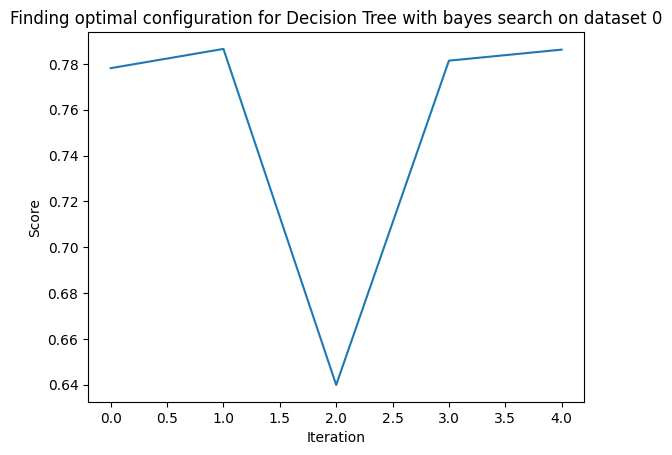

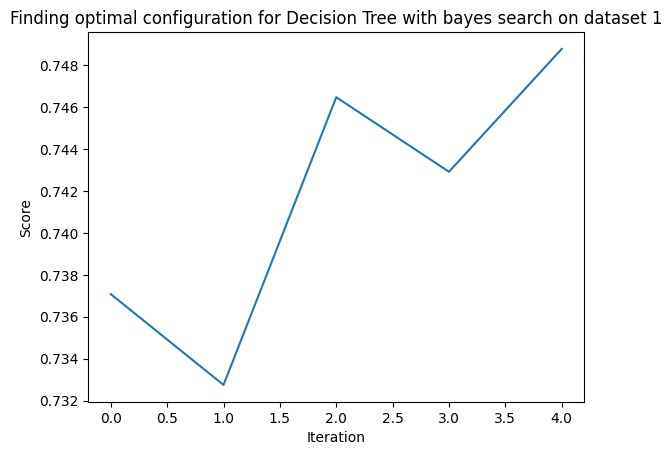

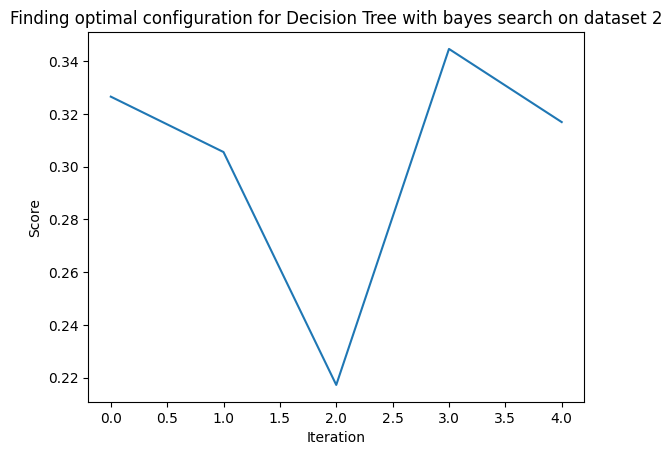

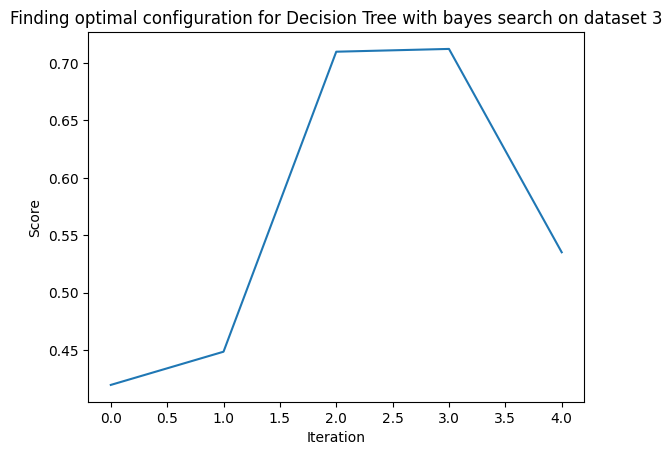

In [20]:
for i in range(len(histories)):
    plt.plot(histories[i])
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(
        f"Finding optimal configuration for Decision Tree with bayes search on dataset {i}"
    )
    plt.show()

## Calculate tunability on each dataset

In [21]:
tunability_per_dataset = calculate_tunability_on_each_dataset(
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    best_configs=best_configs_for_decision_tree,
    optimal_config=optimal_config_decision_tree,
    get_model_pipeline=get_decision_tree_pipeline,
)
dump_tunability_to_csv(
    tunability_per_dataset=tunability_per_dataset,
    filepath="output_data/decision_tree/bayes_tunability.csv",
)

d^j: 0.1252055857502553
d^j: 0.15652922988205342
d^j: -0.00893771665400278
d^j: 0.02820565093188443


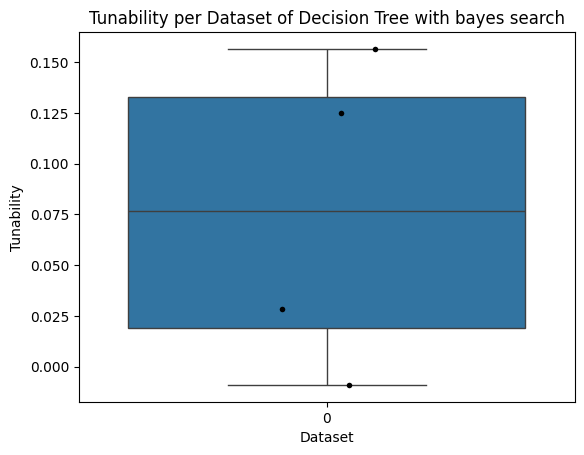

In [22]:
tunability_data = [tunability_per_dataset]

sns.boxplot(data=tunability_data)

# add strip plot
sns.stripplot(data=tunability_data, color="black", size=4)

# add labels and title
plt.xlabel("Dataset")
plt.ylabel("Tunability")
plt.title("Tunability per Dataset of Decision Tree with bayes search")

# show the plot
plt.show()

In [23]:
# aggregated tunability d
print(
    "Aggregated tunability d: "
    + str(calculate_aggregate_tunability(tunability_per_dataset))
)

Aggregated tunability d: 0.0752506874775476


# 2. ElasticNet

## Prepare model and search space

In [7]:
def get_elasticnet_pipeline() -> Pipeline:
    elastic_net = ElasticNet(max_iter=10000)
    col_trans: ColumnTransformer = get_column_transformer()
    decision_tree_pipeline = Pipeline(
        steps=[("column_transformer", col_trans), ("model", elastic_net)]
    )
    return decision_tree_pipeline

In [8]:
def get_parameter_grid_for_elasticnet():
    # parameters space
    random.seed(42)
    alpha = [i * 0.05 for i in range(21)]
    l1_ratio = [i * 0.05 for i in range(21)]
    all_combinations = list(
        itertools.product(
            alpha,
            l1_ratio,
        )
    )
    selected_combinations: List[Tuple[float, int, int, int]] = random.sample(
        all_combinations, NUM_POINTS_RS_ELASTIC_NET
    )
    parameter_names = [
        "model__alpha",
        "model__l1_ratio",
    ]

    parameters_grid_elasticnet = [
        dict(zip(parameter_names, combination)) for combination in selected_combinations
    ]
    return parameters_grid_elasticnet

## Find optimal default hyperparameters 

In [9]:
# find teta*

(
    optimal_config_elasticnet,
    best_summary_score_elasticnet,
    history_scores,
) = find_optimal_configuration_for_all_datasets(
    config_space=get_parameter_grid_for_elasticnet(),
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    model=get_elasticnet_pipeline(),
    summary_func=np.mean,  # Or np.median for a more robust approach
)
dump_optimal_config_search_history(
    history_scores, "output_data/elasticnet/optimal_config_search_history.csv"
)

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\base.py:1152: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.574e+05, tolerance: 1.561e+03 L

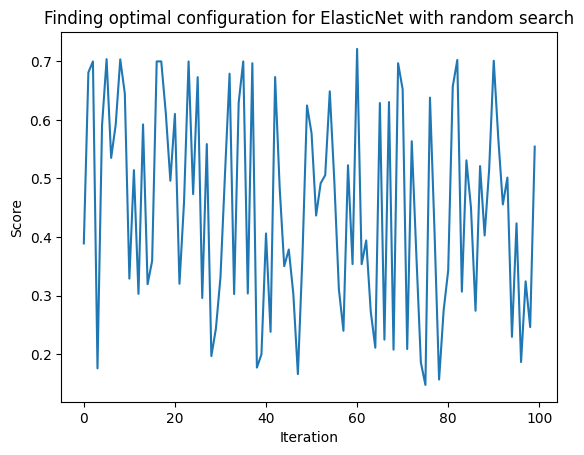

In [10]:
plt.plot(history_scores)
plt.xlabel("Iteration")
plt.ylabel("Score")
plt.title("Finding optimal configuration for ElasticNet with random search")
plt.show()

In [11]:
print(optimal_config_elasticnet)
print(best_summary_score_elasticnet)

{'model__alpha': 0.05, 'model__l1_ratio': 0.9500000000000001}
0.7211635498826843


## Evaluate model with optimal hyperparameters on each dataset

In [12]:
for train_dataset, test_dataset in zip(get_train_datasets(), get_test_datasets()):
    optimal_model: Pipeline = get_elasticnet_pipeline()
    optimal_model.set_params(**optimal_config_elasticnet)
    optimal_model.fit(train_dataset[0], train_dataset[1])
    score = optimal_model.score(test_dataset[0], test_dataset[1])
    print("Optimal elasticnet score on dataset : " + str(score))

Optimal elasticnet score on dataset : 0.9493937083922867
Optimal elasticnet score on dataset : 0.921731887846073
Optimal elasticnet score on dataset : 0.46147913231885185
Optimal elasticnet score on dataset : 0.5520494709735253


## Find best hyperparameters for given dataset with random search

In [13]:
# find tate^(j)*
(
    best_elasticnet_configs_for_each_dataset,
    list_iteration_scores,
) = find_best_configs_in_search_space_with_random_search(
    pipeline=get_elasticnet_pipeline(),
    config_space=get_parameter_grid_for_elasticnet(),
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
)
for i, iteration_scores in enumerate(list_iteration_scores):
    dump_scores_to_csv(
        iteration_scores,
        f"output_data/elasticnet/random_search_iteration_scores_dataset_{i}.csv",
    )

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\base.py:1152: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.574e+05, tolerance: 1.561e+03 L

dataset: 0
score: 0.9507242137010932
best config: {'model__alpha': 0.0, 'model__l1_ratio': 0.6000000000000001}


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.636e+09, tolerance: 5.962e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\base.py:1152: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML

dataset: 1
score: 0.9239290060879508
best config: {'model__alpha': 0.0, 'model__l1_ratio': 0.6000000000000001}


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\base.py:1152: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.063e+05, tolerance: 2.145e+02 L

dataset: 2
score: 0.47157637595237556
best config: {'model__alpha': 0.8500000000000001, 'model__l1_ratio': 1.0}


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\base.py:1152: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.107e+12, tolerance: 4.005e+09 L

dataset: 3
score: 0.5520494709735253
best config: {'model__alpha': 0.05, 'model__l1_ratio': 0.9500000000000001}


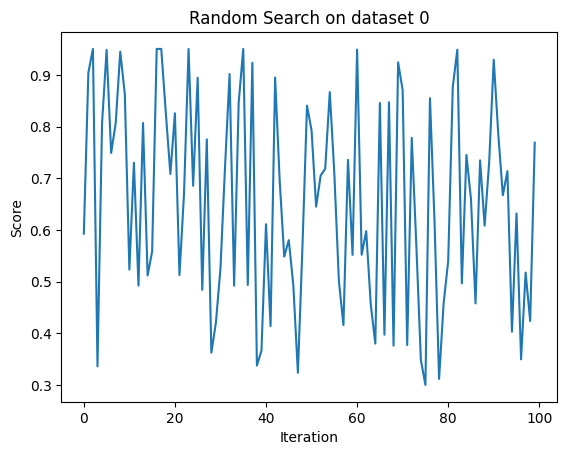

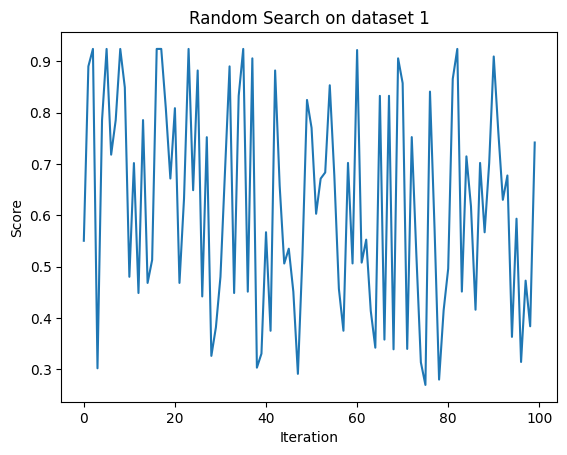

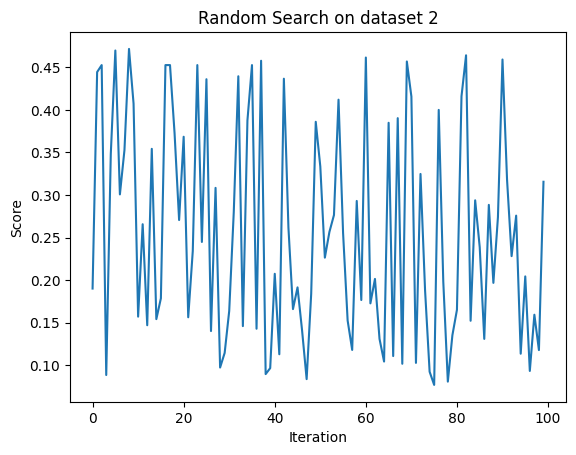

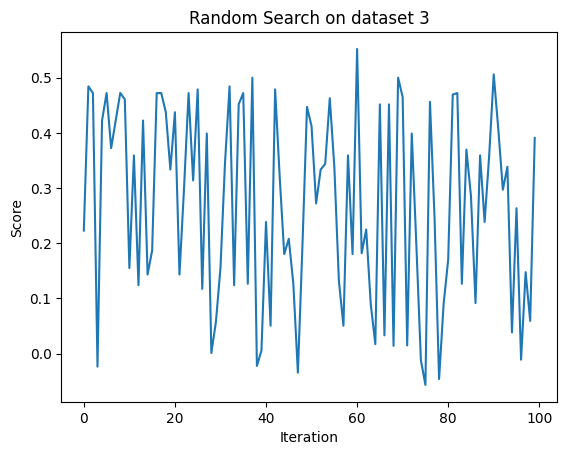

In [14]:
for i, iteration_scores in enumerate(list_iteration_scores):
    plt.plot(iteration_scores)
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(f"Random Search on dataset {i}")
    plt.show()

## Calculate tunability on each dataset

In [15]:
# find d^j

tunability_per_dataset = calculate_tunability_on_each_dataset(
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    best_configs=best_elasticnet_configs_for_each_dataset,
    optimal_config=optimal_config_elasticnet,
    get_model_pipeline=get_elasticnet_pipeline,
)
dump_tunability_to_csv(
    tunability_per_dataset=tunability_per_dataset,
    filepath="output_data/elasticnet/random_search_tunability.csv",
)

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\base.py:1152: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.574e+05, tolerance: 1.561e+03 L

d^j: -0.0013305053088065177


c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.636e+09, tolerance: 5.962e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


d^j: -0.002197118241877849
d^j: -0.010097243633523711
d^j: 0.0


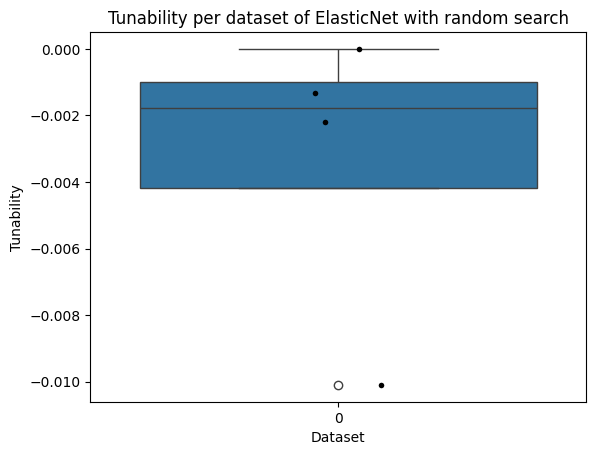

In [16]:
tunability_data = [tunability_per_dataset]

sns.boxplot(data=tunability_data)

# add strip plot
sns.stripplot(data=tunability_data, color="black", size=4)

# add labels and title
plt.xlabel("Dataset")
plt.ylabel("Tunability")
plt.title("Tunability per dataset of ElasticNet with random search")

# show the plot
plt.show()

In [17]:
# aggregated tunability d
print(
    "Aggregated tunability d: "
    + str(calculate_aggregate_tunability(tunability_per_dataset))
)

Aggregated tunability d: -0.0034062167960520195


## Find best hyperparameters for given dataset with bayesian search


In [18]:
def get_bayes_search_space_elasticnet():
    return (
        {
            "model__alpha": Real(0.0, 1.0),
            "model__l1_ratio": Real(0.0, 1.0),
        },
        NUM_ITER_BAYES,
    )

In [19]:
np.int = np.int64  # hack so numpy doesn't complain about missing np.int :)
# calculate all configs
best_configs_for_elasticnet, histories = find_best_configs_in_search_space_with_bayes(
    search_space=get_bayes_search_space_elasticnet(),
    pipeline=get_elasticnet_pipeline(),
    train_datasets=get_train_datasets(),
)
for i, history in enumerate(histories):
    dump_scores_to_csv(
        history, f"output_data/elasticnet/bayes_iteration_scores_dataset_{i}.csv"
    )

Iteration 1: Score = 0.7897749292334564
Iteration 2: Score = 0.7993054515294482
Iteration 3: Score = 0.7143826044264069
Iteration 4: Score = 0.7419804036360375
Iteration 5: Score = 0.376792240103469
Best score: 0.7993054515294482
5
Iteration 1: Score = 0.5830748168156016
Iteration 2: Score = 0.7540332894394078
Iteration 3: Score = 0.8535919377770395
Iteration 4: Score = 0.6324888346843878
Iteration 5: Score = 0.8764170872601671
Best score: 0.8764170872601671
5
Iteration 1: Score = 0.24553894155517977
Iteration 2: Score = 0.1691278726358906
Iteration 3: Score = 0.4300066631260915
Iteration 4: Score = 0.4549117645060939
Iteration 5: Score = 0.35233419181643927
Best score: 0.4549117645060939
5
Iteration 1: Score = 0.6554431428775341
Iteration 2: Score = 0.5044098902142118
Iteration 3: Score = 0.23703757010008725
Iteration 4: Score = 0.6549287895016995
Iteration 5: Score = 0.25444207807173747
Best score: 0.6554431428775341
5


### Plot bayes optimization history for each dataset

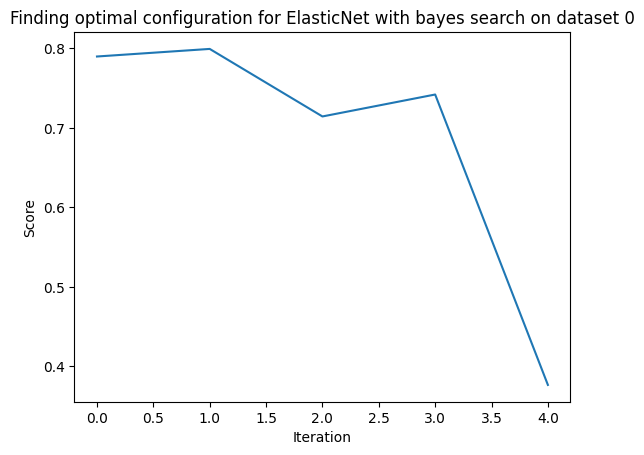

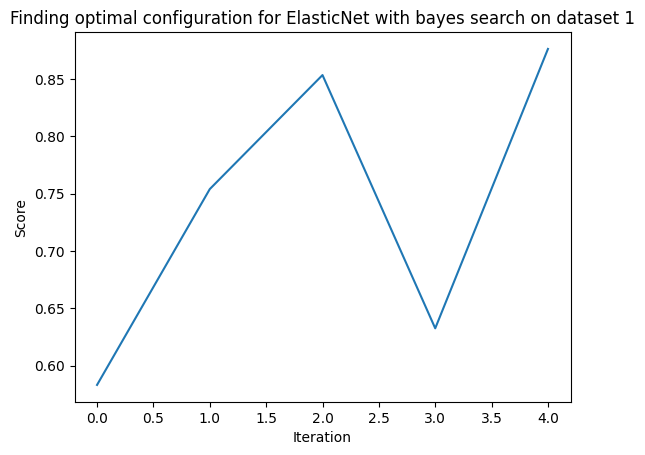

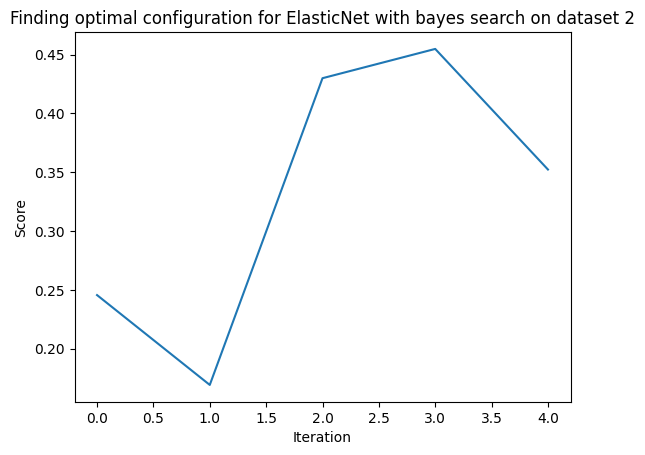

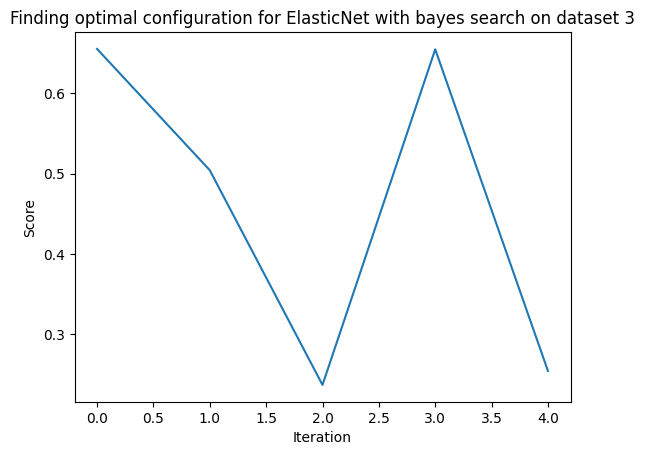

In [20]:
for i in range(len(histories)):
    plt.plot(histories[i])
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(
        f"Finding optimal configuration for ElasticNet with bayes search on dataset {i}"
    )
    plt.show()

## Calculate tunability on each dataset

In [21]:
tunability_per_dataset = calculate_tunability_on_each_dataset(
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    best_configs=best_configs_for_elasticnet,
    optimal_config=optimal_config_elasticnet,
    get_model_pipeline=get_elasticnet_pipeline,
)
dump_tunability_to_csv(
    tunability_per_dataset=tunability_per_dataset,
    filepath="output_data/elasticnet/bayes_tunability.csv",
)

d^j: 0.12037997814359203
d^j: 0.03534615818368303
d^j: 0.001708855116338892
d^j: 0.07527817654302693


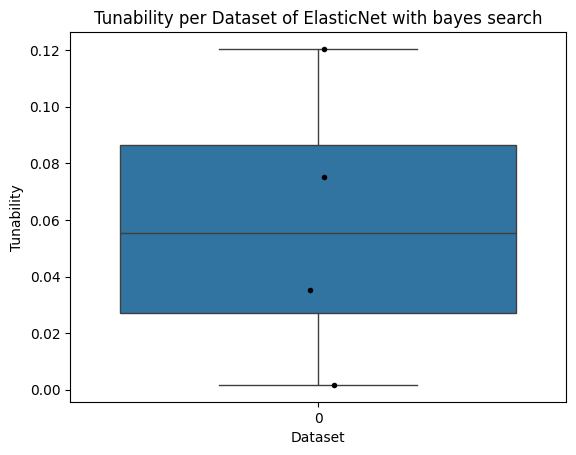

In [22]:
tunability_data = [tunability_per_dataset]

sns.boxplot(data=tunability_data)

# add strip plot
sns.stripplot(data=tunability_data, color="black", size=4)

# add labels and title
plt.xlabel("Dataset")
plt.ylabel("Tunability")
plt.title("Tunability per Dataset of ElasticNet with bayes search")

# show the plot
plt.show()

In [23]:
# aggregated tunability d
print(
    "Aggregated tunability d: "
    + str(calculate_aggregate_tunability(tunability_per_dataset))
)

Aggregated tunability d: 0.05817829199666022


#### 3. Random Forest

In [ ]:
def get_random_forest_pipeline():
    random_forest = RandomForestRegressor()
    col_trans: ColumnTransformer = get_column_transformer()
    random_forest_pipeline = Pipeline(
        steps=[("column_transformer", col_trans), ("model", random_forest)]
    )
    return random_forest_pipeline

In [ ]:
def get_parameter_grid_for_random_forest():
    # parameters space
    random.seed(42)
    max_depth_values = range(1, 31, 1)
    min_samples_split_values = range(2, 61, 1)
    min_samples_leaf_values = range(1, 61, 1)
    n_estimators_values = range(1, 200, 1)

    all_combinations = list(
        itertools.product(
            max_depth_values,
            min_samples_split_values,
            min_samples_leaf_values,
            n_estimators_values,
        )
    )
    selected_combinations: List[Tuple[float, int, int, int]] = random.sample(
        all_combinations, 100
    )
    parameter_names = [
        "model__max_depth",
        "model__min_samples_split",
        "model__min_samples_leaf",
        "model__n_estimators",
    ]

    parameters_grid_random_forest = [
        dict(zip(parameter_names, combination)) for combination in selected_combinations
    ]
    return parameters_grid_random_forest

In [ ]:
train_datasets: List[Tuple[DataFrame, Series]] = get_train_datasets()
random_forest_pipeline: Pipeline = get_random_forest_pipeline()
parameters_grid_random_forest = get_parameter_grid_for_random_forest()

optimal_config_random_forest = find_optimal_configuration_for_all_datasets(
    config_space=parameters_grid_random_forest,
    train_datasets=train_datasets,
    model=random_forest_pipeline,
    summary_func=np.mean,
)

In [ ]:
print(optimal_config_random_forest)

In [ ]:
evaluate_pipeline_on_datasets(
    get_random_forest_pipeline(), optimal_config_random_forest, train_datasets
)

#TODO
- dla każdej konfiguracje z paratmers_grid trzeba ją porównać do optymalnej

### Bayes - decision tree

In [ ]:
decision_tree_params = {
    "model__ccp_alpha": Real(0.11, 1.21, prior="log-uniform"),
    "model__max_depth": Integer(1, 31, prior="log-uniform"),
    "model__min_samples_split": Integer(2, 61, prior="log-uniform"),
    "model__min_samples_leaf": Integer(2, 61, prior="log-uniform"),
}

In [ ]:
config = find_best_config_using_bayes(
    get_decision_tree_pipeline(),
    [(decision_tree_params, 40)],
    X_train_fish_market,
    y_train_fish_market,
)
model = get_decision_tree_pipeline()
model.set_params(**config)
model.fit(X_train_fish_market, y_train_fish_market)
score = model.score(X_test_fish_market, y_test_fish_market)
print(score)